In [1]:
from math import log, sqrt,exp
import math
import numpy as np
from scipy.stats import norm, gmean
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

plt.rcParams["figure.figsize"] = (8,8)
warnings.filterwarnings('ignore')

## Zadanie 1.

Obserwacja zbieżności ceny opcji call z modelu CRR do ceny modelu Blacka-Scholesa.

In [2]:
class CoxRossRubinstein:

    def __init__(self, S: float, K: float, T: float, r: float, sigma: float, N: int):
        
        self.S = S  
        self.K = K    
        self.T = T    
        self.r = r 
        self.sigma=sigma
        self.N = N 

        self.up_factor = math.exp(sigma*np.sqrt(T/N))
        self.down_factor = math.exp(-sigma*np.sqrt(T/N))
        
        self.p = ((math.exp(r*T/N))-self.down_factor)/(self.up_factor-self.down_factor)
        
    def payoff(self, opt_type: str) -> np.array:

        S_T = np.zeros(self.N+1) 
        opt_price = np.zeros(self.N+1) 
        
        S_T[0]=self.S*self.down_factor**self.N
        
        coef = 1 if opt_type == 'call' else -1
        
        for j in range(1, self.N+1): 
            S_T[j] = S_T[j-1] * (self.up_factor/self.down_factor)

        for j in range(1, self.N+1):
                opt_price[j] = max(coef*(S_T[j]-self.K),0)
        return opt_price
    
    def calculate_priceEU(self, opt_type: str) -> float:

        opt_price = self.payoff(opt_type)
        df = math.exp(-self.r*self.T/self.N)
        
        for i in range(self.N, 0, -1):
            for j in range(0, i):
                opt_price[j] = df*(self.p*opt_price[j+1]+(1-self.p)*opt_price[j])
                
        return opt_price[0]

In [3]:
class Black_Scholes:
    def __init__(self, S, K, T, r, sigma):
        self.S = S  
        self.K = K
        self.T = T    
        self.r = r 
        self.sigma = sigma
        
    def calculate_call(self):
        """
        Black-Scholes analytical formula implementation
        """
            
        d1 = (np.log(self.S/self.K) + self.r*self.T)/(self.sigma * np.sqrt(self.T)) + 0.5*self.sigma*np.sqrt(self.T)
        d2 = d1 - self.sigma * np.sqrt(self.T)
                
        return self.S*norm.cdf(d1) - self.K*np.exp(-self.r*self.T)*norm.cdf(d2)

In [4]:
sigma = 0.3
r = 0.05
S = 100.0
K = 110.0
T =  2.221918
x = list(range(50,5000,50))

In [5]:
bs = Black_Scholes(S=S, K=K, T=T, r=r, sigma=sigma)
bs_price = bs.calculate_call()
bs_val = np.repeat(bs_price, len(x), axis=0)

In [6]:
crr_val = []

for n in x:
    crr = CoxRossRubinstein(S, K, T, r, sigma, n)
    crr_val.append(crr.calculate_priceEU('call'))

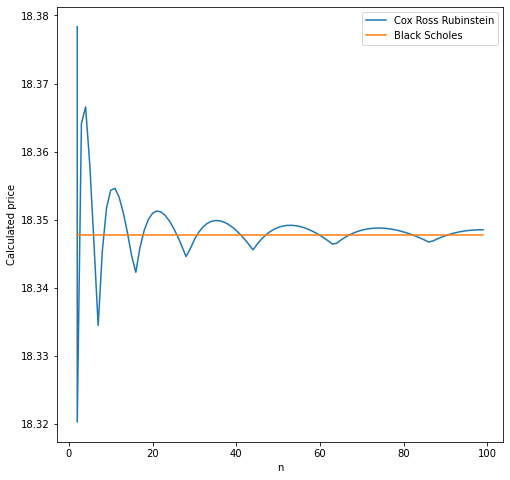

In [7]:
### Wykres
x = np.linspace(2, len(crr_val), len(crr_val), dtype=int)
plt.plot(x, crr_val, label='Cox Ross Rubinstein')
plt.plot(x, bs_val, label = "Black Scholes")
plt.xlabel('n')
plt.ylabel('Calculated price')
plt.legend()
plt.show()

## Zadanie 2.

Korzystajac z metody Monte-Carlo, wycenic w modelu Blacka-Scholesa wypłate europejskiej opcji call.

In [8]:
class MonteCarlo:
    def __init__(self, S, K, T, r, sigma, N):
        self.S = S  
        self.K = K 
        self.T = T    
        self.r = r 
        self.sigma = sigma
        self.N = N        

    # czyste Monte Carlo
    def calculate_payout(self):
                
        # składowe wykładnika exp
        Z = np.random.randn(self.N)
        d = (self.r-(self.sigma**2)/2)*self.T
        
        # wyliczenie S_T z definicji (z wykorzystaniem powyższych składowych)
        S_T = self.S * np.exp(self.sigma * math.sqrt(self.T) * Z + d)
                    
        E_in = np.exp(-self.r*self.T)*np.maximum((S_T-self.K), 0) # element pod wartością oczekiwaną
        E = np.cumsum(E_in)/np.arange(1, len(E_in)+1) # aproksymacja wartości oczekiwanej
        
        return E_in, E
    
    # (a) MC z redukcją wariancji z 1. wariantem metody zmiennych kontrolnych 
    def control_variates(self):
        
        # f(Xi) to u nas liczenie wartości akcji od ST, czyli:
        
        # składowe wykładnika exp
        Z = np.random.randn(self.N)
        d = (self.r-(self.sigma**2)/2)*self.T
        
        S_T = self.S * np.exp(self.sigma * np.sqrt(self.T) * Z + d)
        
        k = np.exp(-self.r * self.T) * S_T
        f = np.exp(-self.r * self.T) * np.maximum((S_T - self.K), 0)
        
        diff = f-k
        E = np.cumsum(k)/np.arange(1, len(k)+1) + np.cumsum(diff)/np.arange(1, len(diff)+1)
        
        return diff, E
    
    
    # (b) MC z redukcją wariancji z 2. wariantem metody zmiennych kontrolnych 
    def control_variates2(self):

        # składowe wykładnika exp
        Z = np.random.randn(self.N)
        d = (self.r-(self.sigma**2)/2)*self.T
        # Y ma być z rozkładu S_T
        Y = self.S * np.exp(self.sigma * math.sqrt(self.T) * Z + d)

        # X ma być z rozkładu e^{-rT}*(S_T-K)_{+}
        X = np.exp(-self.r*self.T) * np.maximum(Y-self.K, 0)
        
        b = sum((X-X.mean())*(Y - Y.mean()))/sum(np.power((Y - Y.mean()), 2))

        # E = b * self.S * np.exp(self.r*self.T) + (X - b*Y).mean()
        diff = X-b*Y
        E = np.cumsum(b*Y)/np.arange(1, len(b*Y)+1) + np.cumsum(diff)/np.arange(1, len(diff)+1)

        return diff, E
    
    # (c) Metoda zmiennych antytetycznych
    def antithetic_method(self):

        # składowe wykładnika exp
        Z = np.random.randn(self.N)
        d = (self.r-(self.sigma**2)/2)*self.T
        
        ST = self.S * np.exp(self.sigma * math.sqrt(self.T) * Z + d)
        f = np.exp(-self.r * self.T) * np.maximum((ST - self.K), 0)
        
        antithetic_ST = self.S * np.exp(self.sigma * math.sqrt(self.T) * (-Z) + d)
        antithetic_f = np.exp(-self.r * self.T) * np.maximum((antithetic_ST - self.K), 0)
        
        # Y = (f + antithetic_f)/2
        E_in = (f + antithetic_f)/2
        E = np.cumsum(E_in)/np.arange(1, len(E_in)+1)
        return E_in, E
    
    # (d) Metoda warstwowania
    def stratified_sampling(self, k):
        if self.N%k != 0: return None
        else: n = int(N/k)

        # variables from specified distribution
        U = np.random.uniform(0, 1, n)
        W = [math.sqrt(self.T)*norm.ppf((i-1+U)/k) for i in range(1, k+1)]
        d = (self.r-(self.sigma**2)/2)*self.T
        
        
        S_T = [np.exp(-self.r * self.T) * np.maximum(((self.S * np.exp(self.sigma * w + d)) - self.K), 0) for w in W]
        means = [np.maximum(f, 0).mean() for f in S_T]
        E = 0
        
        for i in range(len(means)):
            E += means[i]/k
        
        return E
    
    # (e) Metoda importance sampling
    def importance_sampling(self, mi):
        
        Y = np.random.normal(loc=mi, scale=math.sqrt(self.T), size=self.N)
        d = (self.r-(self.sigma**2)/2)*self.T
        
        q = np.exp(-self.r * self.T) * np.maximum((self.S * np.exp(self.sigma * Y + d)-self.K), 0)
        E_in = q * norm.pdf(Y, 0, math.sqrt(self.sigma**2 * self.T))/norm.pdf(Y, mi, math.sqrt(self.T))
    
        E = np.cumsum(E_in)/np.arange(1, len(E_in)+1)
        
        return E_in, E

In [9]:
# Global parameters setting
start=int(1e4)
loops=5
N=int(1e6)

### Czyste Monte Carlo

### $K = 80$

[14452.308180640766, 14911.383079384766, 14767.848941687656, 14734.932164935304, 14360.22229813141]


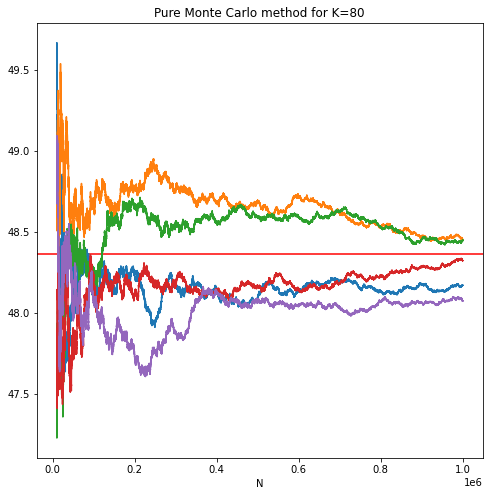

In [10]:
bs = Black_Scholes(S=100, K=80, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.calculate_payout()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Pure Monte Carlo method for K=80')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### $K = 120$

[12547.234458774987, 12414.683813155594, 12725.422680402997, 12607.804079059728, 12816.410925756814]


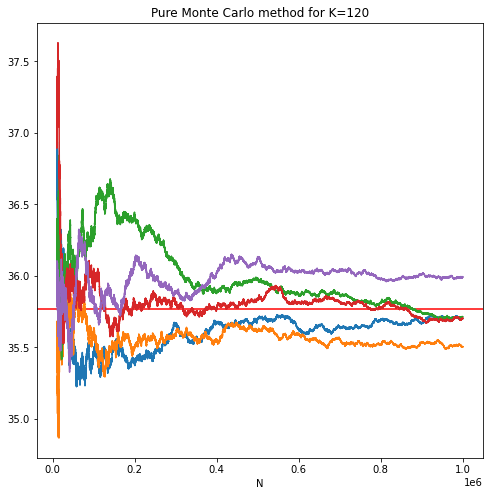

In [11]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.calculate_payout()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Pure Monte Carlo method for K=120')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### (a) MC z redukcją wariancji z 1. wariantem metody zmiennych kontrolnych 

### $K = 80$

[514.4355110266881, 515.1928834588725, 514.4402461231944, 513.6651402685037, 513.7979151891233]


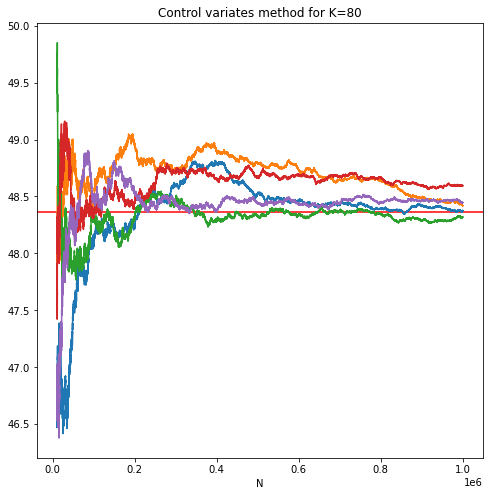

In [12]:
bs = Black_Scholes(S=100, K=80, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.control_variates()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Control variates method for K=80')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### $K = 120$

[1302.8793684678203, 1302.2813438470314, 1300.629599116184, 1301.839223080093, 1301.7481771304217]


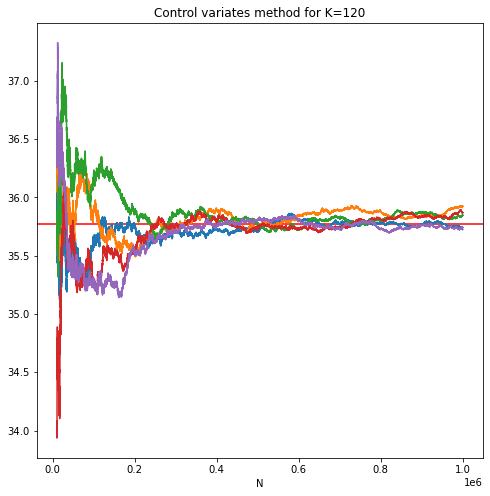

In [13]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.control_variates()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Control variates method for K=120')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### (b) MC z redukcją wariancji z 2. wariantem metody zmiennych kontrolnych 

### $K = 80$

[383.2768946718473, 378.0188850424974, 380.01984997339815, 379.6903766295623, 380.10638615443736]


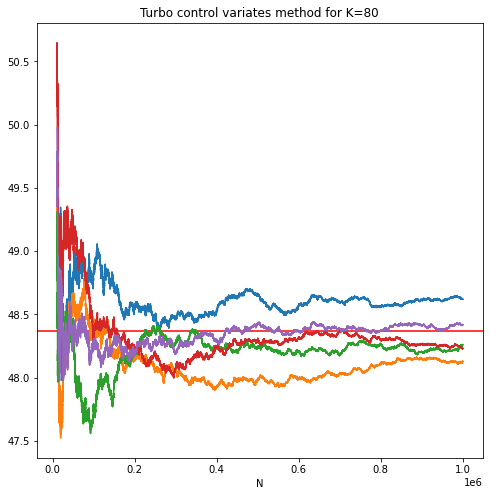

In [14]:
bs = Black_Scholes(S=100, K=80, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.control_variates2()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Turbo control variates method for K=80')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### $K = 120$

[812.4212586511217, 811.2155794076112, 808.8123011148396, 817.6322665594905, 821.2537405390553]


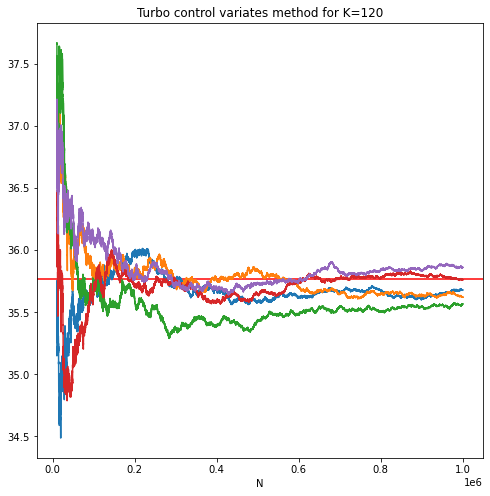

In [15]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.control_variates2()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Turbo control variates method for K=120')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### (c) Metoda zmiennych antytetycznych

### $K = 80$

[6074.298871709676, 6121.798395172141, 6065.293060433049, 6172.946363858673, 6118.545947793426]


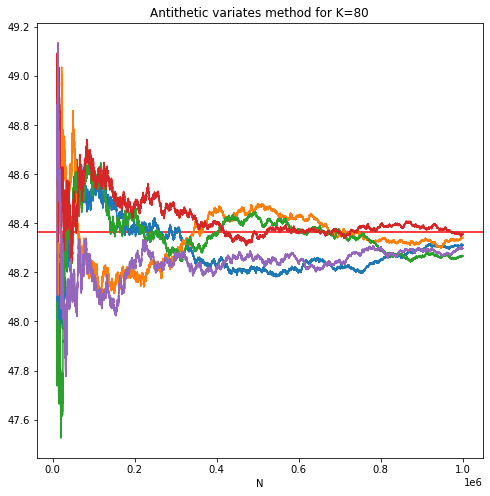

In [16]:
bs = Black_Scholes(S=100, K=80, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.antithetic_method()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Antithetic variates method for K=80')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### $K = 120$

[5643.207400936578, 5703.0162071303075, 5701.659032436261, 5733.615495533118, 5791.077539256926]


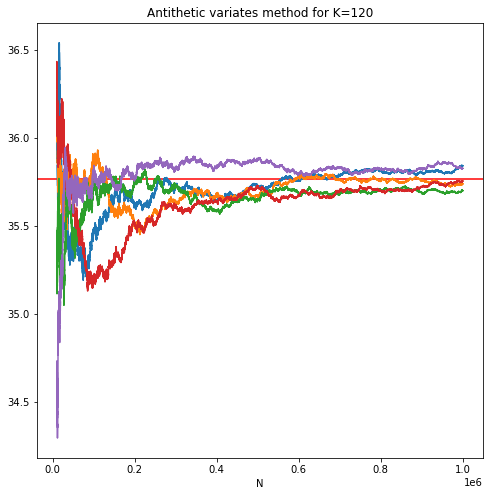

In [17]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.antithetic_method()
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Antithetic variates method for K=120')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### (d) Metoda warstwowania

### $K = 80$

In [18]:
# metoda zbyt wymagająca obliczeniowo, aby móc stworzyć wizualizację analogiczną do poprzednich
model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
model.stratified_sampling(20)

48.32079622370931

### $K = 120$

In [19]:
model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
model.stratified_sampling(20)

35.71094313085774

### (e) Metoda importance sampling

In [20]:
model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
mi_vector = np.linspace(1e-5, 5, 100)
X_var_vector = []
for mi in mi_vector:
    (E_in, E_vect) = model.importance_sampling(mi)
    X_var_vector.append(np.var(E_in))

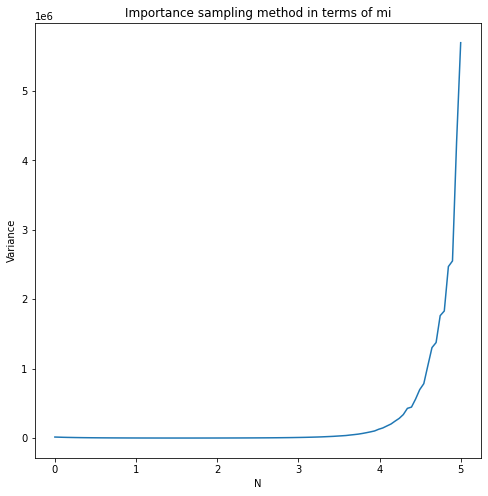

In [21]:
plt.plot(mi_vector, X_var_vector)
plt.ylabel("Variance")
plt.xlabel("N")
plt.title('Importance sampling method in terms of mi')
plt.show()

### $K = 80$

[420.5434814378654, 420.2324947295713, 422.03101669366606, 421.3065740220608, 421.0475612850364]


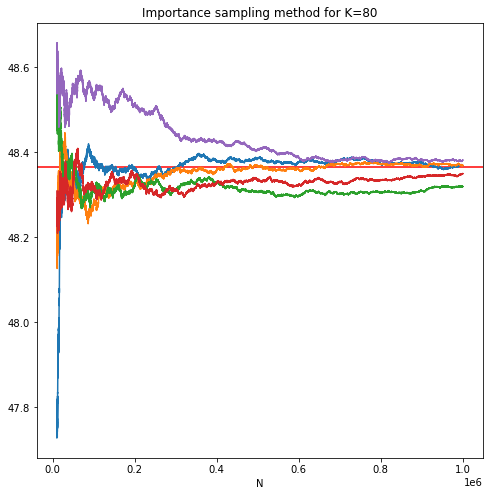

In [22]:
bs = Black_Scholes(S=100, K=80, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=80, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.importance_sampling(1.7)
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Importance sampling method for K=80')
    variances.append(np.var(E_in))
print(variances)
plt.show()

### $K = 120$

[322.4736436859121, 322.5642795458563, 322.82363319691336, 323.08995241215604, 321.8193910008425]


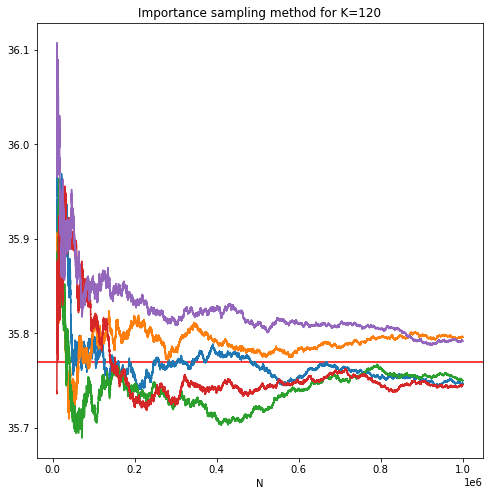

In [23]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(loops):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (E_in, E_vect) = model.importance_sampling(1.7)
    plt.plot(np.arange(start, N), E_vect[start:])
    plt.xlabel("N")
    plt.title('Importance sampling method for K=120')
    variances.append(np.var(E_in))
print(variances)
plt.show()

## Dodatkowo

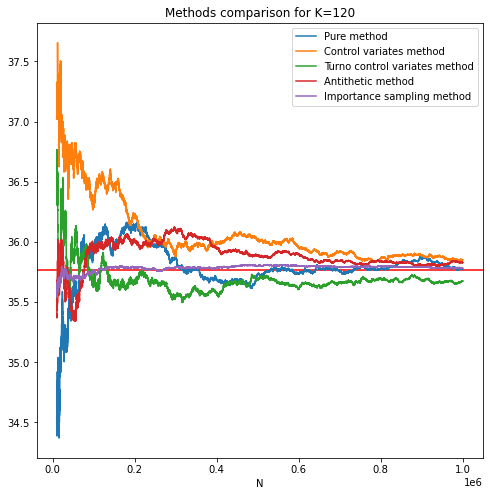

In [24]:
bs = Black_Scholes(S=100, K=120, T=1, r=0.1, sigma=1)
bs_price = bs.calculate_call()
plt.axhline(bs_price, color='red')
variances = []
for i in range(1):
    model = MonteCarlo(S=100, K=120, T=1, r=0.1, sigma=1, N=int(1e6))
    (_, E_vect1) = model.calculate_payout()
    plt.plot(np.arange(start, N), E_vect1[start:], label = 'Pure method')
    
    (_, E_vect2) = model.control_variates()
    plt.plot(np.arange(start, N), E_vect2[start:], label = 'Control variates method')
    
    (_, E_vect3) = model.control_variates2()
    plt.plot(np.arange(start, N), E_vect3[start:], label = 'Turno control variates method')
    
    (_, E_vect4) = model.antithetic_method()
    plt.plot(np.arange(start, N), E_vect4[start:], label = 'Antithetic method')

    (_, E_vect5) = model.importance_sampling(1.7)
    plt.plot(np.arange(start, N), E_vect5[start:], label = 'Importance sampling method')
    
    plt.xlabel("N")
    plt.legend()
    plt.title('Methods comparison for K=120')
plt.show()

## Zadanie 3

Wycenić w modelu Blacka-Scholesa wypłatę opcji azjatyckiej daną przez: $(\frac{1}{N} \sum_{i=1}^{N}S_{T_{i}}-K)_{+}$

In [2]:
def wiener_process_generator(T):
    wiener = np.zeros(T)
    wiener[0] = np.random.normal(0, 1)
    for i in range(1, T):
        wiener[i] = wiener[i-1] + np.random.normal(0, 1)
    return wiener

In [3]:
class AsianOption:
    def __init__(self, S, K, T, r, sigma, N=int(0.3*1e6)):
        self.S = S  
        self.K = K 
        self.T = T    
        self.r = r 
        self.sigma = sigma
        self.N = N        

    def calculate_payoff(self):
        E_in = []
        for i in range(self.N):
            wiener_process = wiener_process_generator(self.T)
            S_T = [self.S * np.exp(self.sigma * W + (self.r-0.5*self.sigma**2)*(t+1)) for t, W in enumerate(wiener_process)]
            value = [np.exp(-self.r*self.T) * max(np.mean(S_T) - self.K, 0)]
            E_in.append(value)
        E = np.cumsum(E_in)/np.arange(1, len(E_in)+1)
        return E_in, E
    
    def asian_payoff(self):
        alfa = self.sigma * np.sum([np.sqrt(t) for t in range(1, self.T+1)])/self.T
        beta = np.log(self.S) + (self.r - 0.5*self.sigma**2)*0.5*(1+self.T)
        c = np.exp(beta + 0.5*alfa**2) * norm.cdf((beta-np.log(self.K)+alfa**2)/np.abs(alfa))- self.K*\
            norm.cdf((beta - np.log(self.K))/np.abs(alfa))
        return np.exp(-self.r*self.T)*c

    def control_variable_payoff(self):
        E_in = []
        for i in range(self.N):
            wiener_process = wiener_process_generator(self.T)
            S_T = [self.S * np.exp(self.sigma * W + (self.r-0.5*self.sigma**2)*(t+1)) for t, W in enumerate(wiener_process)]
            value = [np.exp(-self.r*self.T) * (max(np.mean(S_T) - self.K, 0) - max(gmean(S_T) - self.K, 0))]
            E_in.append(value)
        payout = self.asian_payoff()
        E = np.cumsum(E_in)/np.arange(1, len(E_in)+1) + payout
        return E_in, E

## $K=80$

### Czyste Monte Carlo

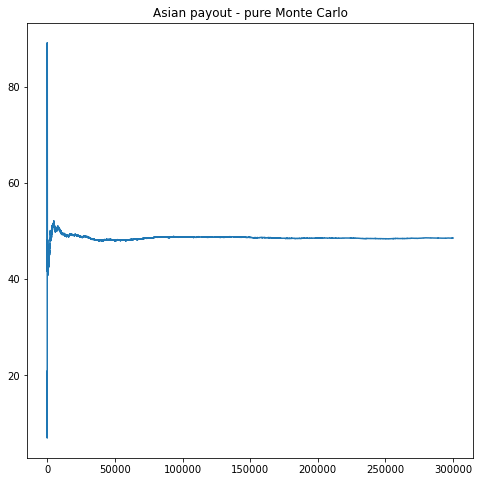

14680.63746984697


In [4]:
model = AsianOption(S=100, K=80, T=1, r=0.1, sigma=1)

(E_in, E) = model.calculate_payoff()
plt.plot(E)
plt.title("Asian payout - pure Monte Carlo")
plt.show()

print(np.var(E_in))

### Metoda zmiennych kontrolnych

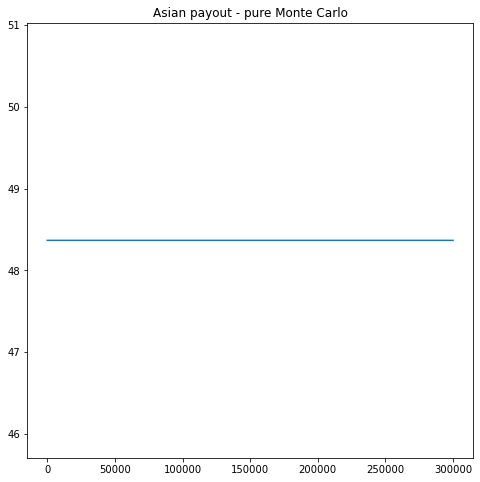

2.2575469714114585e-27


In [5]:
model = AsianOption(S=100, K=80, T=1, r=0.1, sigma=1)

(E_in, E) = model.control_variable_payoff()
plt.plot(E)
plt.title("Asian payout - pure Monte Carlo")
plt.show()

print(np.var(E_in))

## $K=120$

### Czyste Monte Carlo

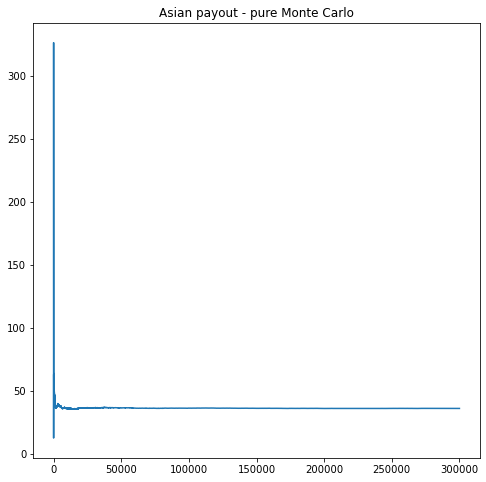

12718.982770097407


In [6]:
model = AsianOption(S=100, K=120, T=1, r=0.1, sigma=1)

(E_in, E) = model.calculate_payoff()
plt.plot(E)
plt.title("Asian payout - pure Monte Carlo")
plt.show()

print(np.var(E_in))

### Metoda zmiennych kontrolnych

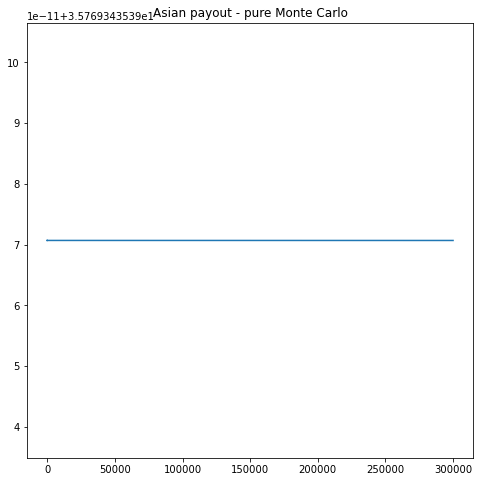

2.2635237775049652e-27


In [8]:
model = AsianOption(S=100, K=120, T=1, r=0.1, sigma=1)

(E_in, E) = model.control_variable_payoff()
plt.plot(E)
plt.title("Asian payout - pure Monte Carlo")
plt.show()

print(np.var(E_in))